In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.interpolate import interp1d
import sys
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import Normalize
from matplotlib import cm
import plotly.graph_objects as go
from scipy.special import lpmv

In [2]:
def check_endianness(filename):
  f=open(filename,'rb')
  #little endian
  version=np.fromfile(f,np.int32,count=1)[0]
  endian='l'
  if abs(version) > 100:
    f.close()
    f=open(filename,'rb')
    version=np.fromfile(f,'>i4',count=1)[0]
    endian='B'
  access='st'
  f.close()
  return version,endian,access

def read_stream_G(filename,endian):
  f=open(filename,'rb')
  fmt='>i4'
  version=np.fromfile(f,np.int32,count=1)[0]
  fmt='>S64'
  runID=np.fromfile(f, fmt, count=1)[0]
  time=np.fromfile(f,np.float32,count=1)[0]
  print("time from G files=",time)
  if version>13:
    ra,pr,axi,sc,ek,stef,prmag,radratio,sigma=np.fromfile(f,np.float32,count=9)
  else:
    ra,pr,axi,sc,ek,prmag,radratio,sigma=np.fromfile(f,np.float32,count=8)
    stef=0.0
  fmt='>i4'
  nr,ntheta,npi,minc,n_r_ic_max=np.fromfile(f,np.int32,count=5)
  if npi==2*ntheta:
    npi=int(npi/minc)
  nphi=npi*minc+1

  if version>13:
    l_heat,l_chem,l_phase,l_mag,l_press,l_cond_ic=np.fromfile(f,np.int32,count=6)
  else:
    l_heat,l_chem,l_mag,l_press,l_cond_ic=np.fromfile(f,np.int32,count=5)
    l_phase=False
  colatitude=np.fromfile(f,np.float32,ntheta)
  radius=np.fromfile(f,np.float32,nr)
  if(l_mag!=0 and n_r_ic_max>1):
    radius_ic=np.fromfile(f,np.float32,n_r_ic_max)

  vr=np.zeros((npi,ntheta,nr),np.float32)
  vtheta=np.zeros_like(vr)
  vphi=np.zeros_like(vr)
  if l_heat!=0:
    entropy=np.zeros_like(vr)
  if l_press!=0:
    pre=np.zeros_like(vr)


    #outer core
  for i in range(nr):
    dat=np.fromfile(f,np.float32,count=ntheta*npi)
    vr[:,:,i]=dat.reshape(npi,ntheta)
    dat=np.fromfile(f,np.float32,count=ntheta*npi)
    vtheta[:,:,i]=dat.reshape(npi,ntheta)
    dat=np.fromfile(f,np.float32,count=ntheta*npi)
    vphi[:,:,i]=dat.reshape(npi,ntheta)
    if l_heat!=0:
      dat=np.fromfile(f,np.float32,count=ntheta*npi)
      entropy[:,:,i]=dat.reshape(npi,ntheta)
    if l_press!=0:
      dat=np.fromfile(f,np.float32,count=ntheta*npi)
      pre[:,:,i]=dat.reshape(npi,ntheta)
  radius_rev=radius[...,::-1]
  vr_rev=vr[...,::-1]
  vtheta_rev=vtheta[...,::-1]
  vphi_rev=vphi[...,::-1]
  entropy_rev=entropy[...,::-1]
  radius_rev=radius[::-1]

  f.close()
  #list_1=[version,runID]
  #list_2=[time,ra,pr,axi,sc,ek,stef,prmag,radratio,sigma]
  #list_3=[nr,ntheta,nphi,minc,n_r_ic_max]
  #list_4=[l_heat,l_chem,l_phase,l_mag,l_press,l_cond_ic]
  #list_5=[colatitude,radius]
  list_geo=[radius_rev,nphi,ntheta,nr]
  list_vel=[vr_rev,vtheta_rev,vphi_rev,entropy_rev]
  #list_6=[entropy,pre]
  return list_vel,list_geo,minc

In [3]:
def read_stream(filename):
    f=open(filename,'rb')
    version=np.fromfile(f,np.int32,count=1)[0]#read the version
    time,Ra,Pr,Raxi,Sc,Prmag,Ek,radratio,sigma_ratio=np.fromfile(f,np.float32,count=9)#read the parameters
    print("time from potential file=",time)
    n_r_max,n_r_ic_max,l_max,minc,lm_max=np.fromfile(f,np.int32,count=5)
    m_min,m_max=np.fromfile(f,"{}2i4".format('<'),count=1)[0]
    omega_ic,omega_max=np.fromfile(f,np.float32,count=2)#rotation
    radius=np.fromfile(f,"{}{}f4".format('<',n_r_max),count=1)[0]#radius
    radius=radius[::-1]
    rho=np.fromfile(f,"{}{}f4".format('<',n_r_max),count=1)[0]#background density
    pol=np.fromfile(f,"{}({},{})c8".format('<',n_r_max,lm_max),count=1)[0]#poloidal potential
    pol=pol.T
    tor=np.fromfile(f,"{}({},{})c8".format('<',n_r_max,lm_max),count=1)[0]#toroidal potential
    tor=tor.T
    params=[time,Ra,Pr,Raxi,Sc,Prmag,Ek,radratio,sigma_ratio]
    rad_sph_params=[n_r_max,n_r_ic_max,l_max,minc,lm_max,m_max,m_min]
    omega=[omega_ic,omega_max]
    rad=[radius]
    rho_list=[rho]
    potentials=[pol,tor]
    return version,params,rad_sph_params,omega,rad,rho_list,potentials

def chebgrid(nr,a,b):
    rst=(a+b)/(b-a)
    rr=0.5*(rst+np.cos(np.pi*(1.-np.arange(nr+1.))))*(b-a)
    return rr

def matder(data,rad,exclude=False):
    r1=rad[0]
    r2=rad[-1]
    nr=data.shape[-1]
    grid=chebgrid(nr-1,r1,r2)
    tol=1e-6
    diff=abs(grid-rad).max()
    if diff>tol:
        spectral=False
        grid=rad
    else:
        spectral=True

    if spectral:
        d1=matder(nr-1,r1,r2)
        if (data.shape)==1:
            der=np.dot(d1,data)
        elif len(data.shape)==2:
            der=np.tensordot(data,d1,axes=[1,1])
        else:
            der=np.tensordot(data,d1,axes=[2,1])
    else:
        denom=np.roll(grid,-1)-np.roll(grid,1)
        denom[0]=grid[1]-grid[0]
        denom[-1]=grid[-1]-grid[-2]
        der=(np.roll(data,-1,axis=-1)-np.roll(data,1,axis=-1))/denom
        der[...,0]=(data[...,1]-data[...,0])/(grid[1]-grid[0])
        der[...,-1]=(data[...,-1]-data[...,-2])/(grid[-1]-grid[-2])
    return der

def area_avg(data,phi,theta):
    sum=0.0
    dtheta,dphi=theta[1]-theta[0],phi[1]-phi[0]
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            sum+=data[i,j]*np.sin(theta[i])*dtheta*dphi
    sum=(sum)/(4*np.pi)
    return sum

In [4]:
class Legendre:
    def __init__(self,l_max,minc,n_theta_max,m_max):
        #maximum degree and order
        self.l_max=l_max
        self.m_max=m_max
        self.minc=minc
        self.n_m_max=m_max//minc+1
        self.n_theta_max=n_theta_max
        self.n_phi_max=n_theta_max*2//2

        self.get_index,self.offsets,self.lm_max=self._build_index_map(l_max,m_max,minc)

        #declare arrays
        self.Plm=np.zeros((self.lm_max,n_theta_max//2))    #P_l^m(cos(theta))
        self.wPlm=np.zeros_like(self.Plm)   #weighted P_l^m
        self.wdPlm=np.zeros_like(self.Plm)  #weighted derivative
        self.dPlm=np.zeros_like(self.Plm)   #derivative wrt theta
        self.dPhi=np.zeros_like(self.Plm)   #derivative wrt phi
        self.sinTh=np.zeros(n_theta_max)  #sin(theta) values
        self.gauss=np.zeros(n_theta_max)  #gauss-legendre polynomial

        #theta and weights
        self.theta_ord,self.gauss=self._gauleg(n_theta_max)

        #indexing arrays
        self.lStart=np.zeros(self.n_m_max,dtype=int)
        self.lStop=np.zeros(self.n_m_max,dtype=int)
        self.lmOdd=np.zeros(self.n_m_max,dtype=bool) #odd even flag

        dpi=np.pi

        for ntheta in range(self.n_theta_max//2):
            colat=self.theta_ord[ntheta]
            plma,dtheta_plma=self._plm_theta(colat,self.l_max,self.m_max,self.minc)
            lm=0
            for m in range(0,self.m_max+1,self.minc):
                for l in range(m,self.l_max+1):
                    self.Plm[lm,ntheta]=((-1.0)**m)*plma[lm]
                    self.dPlm[lm,ntheta]=((-1.0)**m)*dtheta_plma[lm]/(np.sin(colat))
                    self.dPhi[lm,ntheta]=m/(np.sin(colat))
                    self.wPlm[lm,ntheta]=2.0*dpi*self.gauss[ntheta]*self.Plm[lm,ntheta]
                    self.wdPlm[lm,ntheta]=2.0*dpi*self.gauss[ntheta]*self.dPlm[lm,ntheta]
                    lm+=1

        self.lStart,self.lStop,self.lmOdd=self._getblocks(self.l_max,self.minc,self.n_m_max)

    def _filter(self,lm_to_l,lm_to_m,lcut=None,mcut=None):
        lm_mask=lm_to_l.size
        mask=np.ones(self.lm_max,dtype=bool)
        if lcut is not None:
            mask&=(lm_to_l==lcut)
        if mcut is not None:
            mask&=(lm_to_m==mcut)
        return mask

    def _spectra(self):
        return 0

    def _getblocks(self,l_max,minc,n_m_max):
        lStart=np.zeros(n_m_max,dtype=int)
        lStop=np.zeros(n_m_max,dtype=int)
        lmOdd=np.zeros(n_m_max,dtype=int)

        lStart[0]=0#lStart[0]=1
        lStop[0]=l_max#lStop[0]=l_max+1
        lmOdd[0]=(l_max%2==0)

        for mc in range(1,n_m_max):
            m=mc*minc
            lStart[mc]=lStop[mc-1]+1
            lStop[mc]=lStart[mc]+(l_max-m)
            lmOdd[mc]=((lStop[mc]-lStart[mc])%2==0)
            #lStart[mc]=lStop[mc-1]#+1
            #lStop[mc]=lStart[mc]+(l_max-m+1)
            #lmOdd[mc]=((lStop[mc]-lStart[mc])%2==0)
        
        return lStart,lStop,lmOdd

    def _build_index_map(self,l_max,m_max,m0):
        m_values=list(range(0,m_max+1,m0))
        offsets={}
        idx=0
        for m in m_values:
            offsets[m]=idx
            idx+=(l_max-m+1)
        total=idx
        def get_index(m,l):
            return offsets[m]+(l-m)
        return get_index,offsets,total

    def _LMmapping(self,m_min):
        idx=np.zeros((self.l_max+1,self.m_max+1),np.int32)
        lm2l=np.zeros(self.lm_max,np.int16)
        lm2m=np.zeros(self.lm_max,np.int16)
        k=0
        for m in range(m_min,self.m_max+1,self.minc):
            for l in range(m,self.l_max+1):
                idx[l,m]=k
                lm2l[k]=l
                lm2m[k]=m
                k+=1
        return idx,lm2l,lm2m

    def _getLM(self,idx,m_min):
        LM_list=[]
        for m in range(m_min,self.m_max+1,self.minc):
            for l in range(m,self.l_max+1):
                LM_list.append(idx[l,m])
        print("shape of LM list=",len(LM_list))
        return LM_list

    def _pad_lm_array(self,LM_list,pad_factor):
        new_m_max=int(np.ceil(self.m_max*pad_factor))
        print("new n_m_max:",new_m_max,"\t old m_max",self.m_max)
        LM2d=np.zeros((l_max+1,new_m_max+1),np.int32)
        print("LM2D shape=",LM2d.shape)
        index=0
        for m in range(0,self.m_max+1,self.minc):
            for l in range(m,self.l_max+1):
                LM2d[l,m]=LM_list[index]
                index+=1
        padded_list=[]
        for m in range(0,new_m_max+1,self.minc):
            for l in range(m,self.l_max+1):
                padded_list.append(LM2d[l,m])
        padded_LM=np.array(padded_list)        
        return padded_LM

    def _gauleg(self,n_theta_max):
        theta_ord=np.zeros(n_theta_max)
        gauss=np.zeros(n_theta_max)

        dpi=np.pi
        M=(n_theta_max+1)//2
        XXM=0.0
        XXL=1.0
        eps=3e-14

        for i in range(1,M+1):
            zz=np.cos(dpi*((i-0.25)/(n_theta_max+0.5)))
            zz1=0.0

            while abs(zz-zz1)>eps:
                p1=1.0
                p2=0.0
                for j in range(1,n_theta_max+1):
                    p3=p2
                    p2=p1
                    p1=((2*j-1)*zz*p2-(j-1)*p3)/j
                pp=n_theta_max*(zz*p1-p2)/(zz*zz-1.0)
                zz1=zz
                zz=zz1-p1/pp

            theta_ord[i-1]=np.arccos(XXM+XXL*zz)
            theta_ord[n_theta_max-i]=np.arccos(XXM-XXL*zz)
            w=2.0*XXL/((1.0-zz**2)*pp**2)
            gauss[i-1]=w
            gauss[n_theta_max-i]=w
            
        return theta_ord,gauss

    def _specspat_vec(self,dpoldr_LM,tor_LM,nth,nph):
        #define the output 
        ii=1j
        lm_max=len(dpoldr_LM)

        #pre allocate working arrays
        PlmG=np.zeros(lm_max,dtype=np.float64)
        PlmC=np.zeros(lm_max,dtype=np.float64)
        vhG=np.zeros(lm_max,dtype=np.complex128)
        vhC=np.zeros(lm_max,dtype=np.complex128)

        vt=np.zeros((nph,nth),dtype=np.complex128)
        vp=np.zeros((nph,nth),dtype=np.complex128)

        #combined polidal and toroidal potentials
        vhG[:]=dpoldr_LM-ii*tor_LM
        vhC[:]=dpoldr_LM+ii*tor_LM

        dPlm,dPhi,Plm=self.dPlm,self.dPhi,self.Plm

        nThetaNHS=0
        for nThetaN in range(nth//2):
            nThetaS=nth-nThetaN-1
            #nThetaNHS+=1
            #Build PlmG and PlmC

            for n_m in range(self.n_m_max):
                lms=self.lStop[n_m]
                for lm in range(self.lStart[n_m],lms-1,2):
                    PlmG[lm]=dPlm[lm,nThetaNHS]-dPhi[lm,nThetaNHS]*Plm[lm,nThetaNHS]
                    PlmC[lm]=dPlm[lm,nThetaNHS]+dPhi[lm,nThetaNHS]*Plm[lm,nThetaNHS]
                    PlmG[lm+1]=dPlm[lm+1,nThetaNHS]-dPhi[lm+1,nThetaNHS]*Plm[lm+1,nThetaNHS]
                    PlmC[lm+1]=dPlm[lm+1,nThetaNHS]+dPhi[lm+1,nThetaNHS]*Plm[lm+1,nThetaNHS]
                if self.lmOdd[n_m]:
                    PlmG[lms]=dPlm[lms,nThetaNHS]-dPhi[lms,nThetaNHS]*Plm[lms,nThetaNHS]
                    PlmC[lms]=dPlm[lms,nThetaNHS]+dPhi[lms,nThetaNHS]*Plm[lms,nThetaNHS]

            for n_m in range(self.n_m_max):
                lms=self.lStop[n_m]
                vhN1,vhS1,vhN2,vhS2=0.0+0.0j,0.0+0.0j,0.0+0.0j,0.0+0.0j
                for lm in range(self.lStart[n_m],lms-1,2):
                    vhN1+=vhG[lm]*PlmG[lm]+vhG[lm+1]*PlmG[lm+1]
                    vhS1+=-vhG[lm]*PlmC[lm]+vhG[lm+1]*PlmC[lm+1]
                    vhN2+=vhC[lm]*PlmC[lm]+vhC[lm+1]*PlmC[lm+1]
                    vhS2+=-vhC[lm]*PlmG[lm]+vhC[lm+1]*PlmG[lm+1]

                if self.lmOdd[n_m]:
                    vhN1+=vhG[lms]*PlmG[lms]
                    vhS1-=vhG[lms]*PlmC[lms]
                    vhN2+=vhC[lms]*PlmC[lms]
                    vhS2-=vhC[lms]*PlmG[lms]
                vt[n_m,nThetaN]=0.5*(vhN1+vhN2)
                vt[n_m,nThetaS]=0.5*(vhS1+vhS2)
                vp[n_m,nThetaN]=-0.5*ii*(vhN1-vhN2)
                vp[n_m,nThetaS]=-0.5*ii*(vhS1-vhS2)

            nThetaNHS+=1

        if self.n_phi_max>1:
            vt[self.n_m_max:self.n_phi_max//2+1,:]=0.0
            vp[self.n_m_max:self.n_phi_max//2+1,:]=0.0
            for nThetaN in range(self.n_theta_max):
                for n_m in range(self.n_phi_max//2+1,self.n_phi_max):
                    vt[n_m,nThetaN]=np.conj(vt[self.n_phi_max-n_m,nThetaN])
                    vp[n_m,nThetaN]=np.conj(vp[self.n_phi_max-n_m,nThetaN])

        
        return vt,vp

    def _specspat_scal(self,pol,nth,nph):
        ii=1j
        vr=np.zeros((nph,nth),dtype=np.complex128)

        n_m_max_loc=1 if nph==1 else self.n_m_max
        Plm=self.Plm

        for nThetaN in range(nth//2):
            nThetaS=nth-nThetaN-1
            for n_m in range(self.n_m_max):
                lms=self.lStop[n_m]
                s12=0.0+0.0j
                z12=0.0+0.0j
                for lm in range(self.lStart[n_m],lms-1,2):
                    s12+=pol[lm]*Plm[lm,nThetaN]
                    z12+=pol[lm+1]*Plm[lm+1,nThetaN]
                if self.lmOdd[n_m]:
                    s12+=pol[lms]*Plm[lms,nThetaN]
                vr[n_m,nThetaN]=s12+z12
                vr[n_m,nThetaS]=s12-z12

        if nph>1:
            vr[n_m_max_loc:nph//2+1,:]=0.0
            for nThetaN in range(nth):
                for n_m in range(nph//2+1,nph):
                    vr[n_m,nThetaN]=np.conj(vr[nph-n_m,nThetaN])
        
        return vr

    def _plm_theta(self,theta,max_degree,max_order,m0):
        m_values=list(range(0,max_order+1,m0))
        ndim_req=sum((max_degree-m+1) for m in m_values)

        plma=np.zeros(ndim_req,dtype=np.float64)
        dtheta_plma=np.zeros(ndim_req,dtype=np.float64)

        dnorm=1.0/np.sqrt(16.0*np.atan(1.0))

        pos=-1

        for m in m_values:
            fac=1.0
            for j in range(3,2*m+2,2):
                fac*=float(j)/float(j-1)
            plm0=np.sqrt(fac)
            s=np.sin(theta)
            if abs(s)>0.0:
                plm0=plm0*((-s)**m)
            elif m!=0:
                plm0=0.0

            l=m
            pos+=1
            plma[pos]=dnorm*plm0
            plm1=0.0

            for l in range(m+1,max_degree+1):
                plm2=plm1
                plm1=plm0
                num1=(2*l-1)*(2*l+1)
                den1=(l-m)*(l+m)
                term1=np.cos(theta)*np.sqrt(float(num1)/float(den1))*plm1
                num2=(2*l+1)*(l+m-1)*(l-m-1)
                den2=(2*l-3)*(l-m)*(l+m)
                term2=np.sqrt(float(num2)/float(den2))*plm2 if (den2!=0) else 0
                plm0=term1-term2
                pos+=1
                plma[pos]=dnorm*plm0

            l=max_degree+1
            plm2=plm1
            plm1=plm0
            num1=(2*l-1)*(2*l+1)
            den1=(l-m)*(l+m)
            term1=np.cos(theta)*np.sqrt(float(num1)/float(den1))*plm1
            num2=(2*l+1)*(l+m-1)*(l-m-1)
            den2=(2*l-3)*(l-m)*(l+m)
            term2=np.sqrt(float(num2)/float(den2))*plm2
            plm0=term1-term2
            dtheta_plma[pos]=dnorm*plm0
        
        pos=-1
        for m in m_values:
            l=m
            pos+=1
            if m<max_degree:
                dtheta_plma[pos]=(l/np.sqrt(float(2*l+3)))*plma[pos+1]
            else:
                dtheta_plma[pos]=(l/np.sqrt(float(2*l+3)))*plma[pos]

            for l in range(m+1,max_degree):
                pos+=1
                termA=l*np.sqrt(float((l+m+1)*(l-m+1))/float((2*l+1)*(2*l+3)))*plma[pos+1]
                termB=(l+1)*np.sqrt(float((l+m)*(l-m))/float((2*l-1)*(2*l+1)))*plma[pos-1]
                dtheta_plma[pos]=termA-termB

            if m<max_degree:
                l=max_degree
                pos+=1
                termA=l*np.sqrt(float((l+m+1)*(l-m+1))/float((2*l+1)*(2*l+3)))*dtheta_plma[pos]
                termB=(l+1)*np.sqrt(float((l+m)*(l-m))/float((2*l-1)*(2*l+1)))*plma[pos-1]
                dtheta_plma[pos]=termA-termB
        
        return plma,dtheta_plma

In [5]:
from math import factorial
def scipy_norm(l,m):
    return (1/(np.sqrt(2*np.pi)))*np.sqrt((2*l+1)/2*factorial(l-m)/factorial(l+m))

time from potential file= 0.9499
(2401, 97)
(144, 144) (144, 144)
144 144
(144, 144) (144, 144)


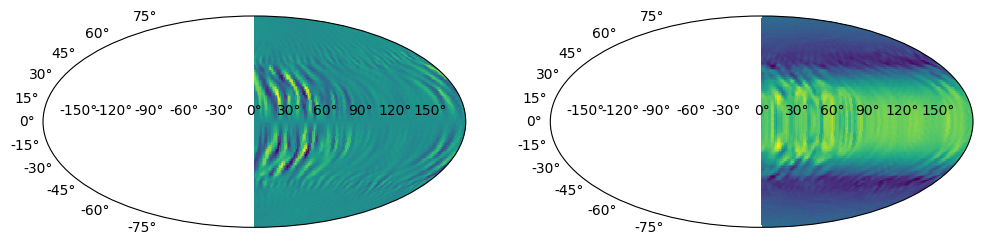

In [6]:
if __name__=="__main__":
    l_max,m_max,minc=6,5,1
    n_theta=250
    leg=Legendre(l_max,minc,n_theta,m_max)
    #print(leg.theta_ord)
    #print(np.cos(leg.theta_ord))
    #x=np.cos(leg.theta_ord)
    #w=leg.gauss

    #for k in [0,2,4,6]:
        #exact=2.0/(k+1) if k%2==0 else 0.0
        #approx=np.sum(w*x**k)
        #print(f"k={k}: exact={exact:.6e}, approx={approx:.6e}, error={abs(exact-approx):.2e}")

    #thet=leg.theta_ord[0]#take theta=0
    #plma,dtheta_pma=leg._plm_theta(thet,l_max,m_max,minc)

    #print("Comparison at theta=%.3f (radians)"%thet)
    #pos=-1
    #for m in range(m_max+1):
        #for l in range(m,l_max+1):
            #pos+=1
            #norms=scipy_norm(l,m)
            #x=np.cos(thet)
            #scipy_val=norms*lpmv(m,l,x)
            #our_val=plma[pos]
            #print(f"(l={l}, m={m}): scipy={scipy_val:.6e}, ours={our_val:.6e}, ratio={our_val/(scipy_val+1e-30):.6e}")

    #print(leg.get_index,leg.lm_max,leg.offsets)

    #pairs=[(0,0),(1,0),(1,1),(2,0),(2,1),(3,0),(3,2),(3,3)]

    #print(leg.theta_ord[:leg.n_theta_max//2].shape)
    #half_sph=leg.theta_ord[:leg.n_theta_max//2]
    #x=np.cos(half_sph)
    #n_plots=len(pairs)

    #fig,axes=plt.subplots(nrows=len(pairs)//2+len(pairs)%2,ncols=2,figsize=(10,10))

    #axes=axes.flatten()

    #for i,(l,m) in enumerate(pairs):
        #ax=axes[i]
        #idx=leg.get_index(m,l)
        #our_val=leg.Plm[idx,:]
        #norms=scipy_norm(l,m)
        #scipy_val=norms*lpmv(m,l,x)

        #ax.plot(half_sph,our_val,linewidth=4.0,label=f"magIC l={l}, m={m}")
        #ax.plot(half_sph,scipy_val,'--',label=f"scipy l={l},m={m}")
        #ax.set_xlabel(r"$\theta$")
        #ax.set_ylabel(r"$P_\ell^m(\cos\theta)$")
        #ax.grid(True)
        #ax.legend(fontsize=8)
        #ax.set_title(f"(l={l},m={m})")
    

    #for l,m in pairs:
        #idx=leg.get_index(m,l)
        #our_val=self.Plm[idx,:]
    #plt.suptitle(f"comparisons")
    #plt.tight_layout(rect=[0,0,1,0.96])
    #plt.show()

    #print(leg.lStart,leg.lStop,leg.lmOdd)

    version,params,rad_sph_params,omega,rad,rho_list,potentials=read_stream('V_lmr_1000.test_BIS')
    
    poloidal,toroidal=potentials[0],potentials[1]
    print(poloidal.shape)
    radius=rad[0]
    #contruct dpoldr to find the theta and phi components
    dpoldr=np.zeros_like(poloidal)
    dpoldr=matder(poloidal,radius,False)
    l_max,minc,lm_max,m_max,m_min=rad_sph_params[2],rad_sph_params[3],rad_sph_params[4],rad_sph_params[5],rad_sph_params[6]
    n_theta=144
    leg=Legendre(l_max,minc,n_theta,m_max)
    #print(leg.lStart,leg.lStop,leg.lmOdd)
    #print(leg.lStart.shape,leg.lStop.shape,leg.lmOdd.shape)
    vt,vp=leg._specspat_vec(dpoldr[:,0],toroidal[:,0],leg.n_theta_max,leg.n_phi_max)
    print(vt.shape,vp.shape)
    vt=np.fft.ifft(vt,axis=0)*leg.n_phi_max
    vp=np.fft.ifft(vp,axis=0)*leg.n_phi_max
    vt,vp=vt.real,vp.real
    vt,vp=vt.T,vp.T

    nlon,nlat=vt.shape[0],vt.shape[1]
    print(nlon,nlat)
    phi_plot,theta_plot=np.linspace(0,np.pi,nlon),np.linspace(0,np.pi,nlat)
    phi_grid,theta_grid=np.meshgrid(phi_plot,theta_plot)
    theta_grid=theta_grid-np.pi/2
    print(phi_grid.shape,theta_grid.shape)
    fig,axes=plt.subplots(1,2,figsize=(12,5),subplot_kw={'projection':'mollweide'})
    axes[0].pcolormesh(phi_grid,theta_grid,vt,shading='auto')
    axes[1].pcolormesh(phi_grid,theta_grid,vp,shading='auto')

    plt.show()
    

time from potential file= 0.9499
(2401, 97)
shape of vt= (144, 144) 	 shape of vp= (144, 144)
shape of vr= (144, 144)
144 144
(144, 144) (144, 144)
shape after tile vt = (144, 288) 	 vp = (144, 288) 	 vr= (144, 288)
new nlon = 288 	 nlat = 144
new phi grid = (144, 288) 	 new theta grid (144, 288)


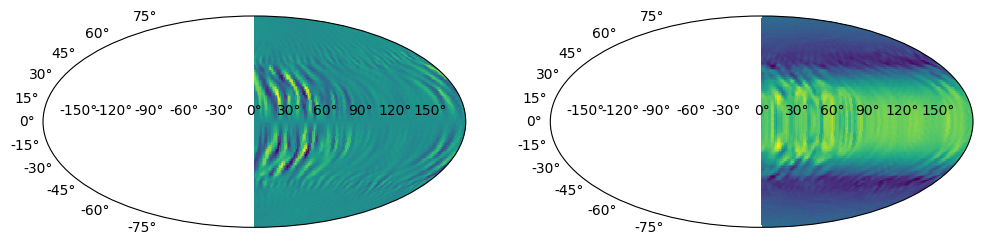

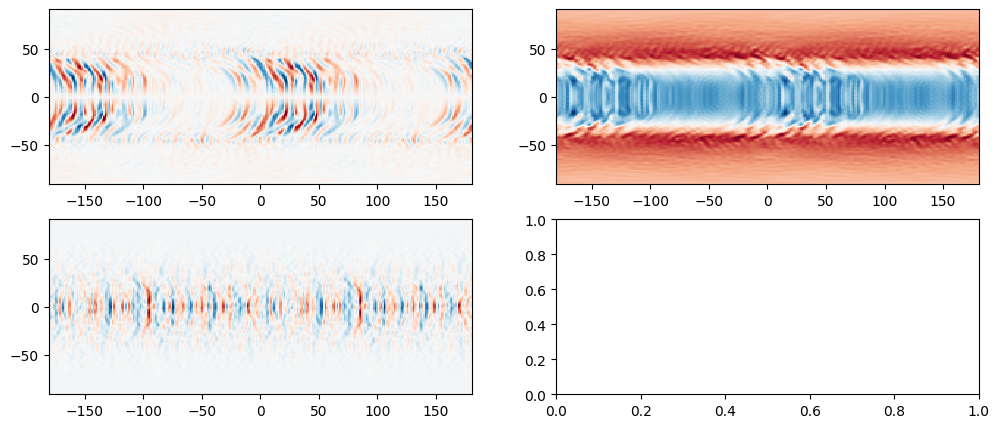

In [7]:
if __name__=="__main__":
    l_max,m_max,minc=6,5,1
    n_theta=250
    leg=Legendre(l_max,minc,n_theta,m_max)

    version,params,rad_sph_params,omega,rad,rho_list,potentials=read_stream('V_lmr_1000.test_BIS')
    
    poloidal,toroidal=potentials[0],potentials[1]
    print(poloidal.shape)
    radius=rad[0]
    #contruct dpoldr to find the theta and phi components
    dpoldr=np.zeros_like(poloidal)
    dpoldr=matder(poloidal,radius,False)
    l_max,minc,lm_max,m_max,m_min=rad_sph_params[2],rad_sph_params[3],rad_sph_params[4],rad_sph_params[5],rad_sph_params[6]
    n_theta=144
    leg=Legendre(l_max,minc,n_theta,m_max)
    #print(leg.lStart,leg.lStop,leg.lmOdd)
    #print(leg.lStart.shape,leg.lStop.shape,leg.lmOdd.shape)
    vt,vp=leg._specspat_vec(dpoldr[:,0],toroidal[:,0],leg.n_theta_max,leg.n_phi_max)
    print("shape of vt=",vt.shape,"\t shape of vp=",vp.shape)
    vt=np.fft.ifft(vt,axis=0)*leg.n_phi_max
    vp=np.fft.ifft(vp,axis=0)*leg.n_phi_max
    vt,vp=vt.real,vp.real
    vt,vp=vt.T,vp.T

    #radial component
    inputLM=np.zeros_like(poloidal)
    indx,lm2l,lm2l=leg._LMmapping(m_min)
    for i in range(radius.shape[0]):
        inputLM[:,i]=poloidal[:,i]*lm2l*(lm2l+1)/radius[i]**2
    vr=leg._specspat_scal(inputLM[:,0],leg.n_theta_max,leg.n_phi_max)
    vr=np.fft.ifft(vr,axis=0)*leg.n_phi_max
    vr=vr.real
    vr=vr.T
    print("shape of vr=",vr.shape)
    

    nlon,nlat=vt.shape[0],vt.shape[1]
    print(nlon,nlat)
    phi_plot,theta_plot=np.linspace(0,np.pi,nlon),np.linspace(0,np.pi,nlat)
    phi_grid,theta_grid=np.meshgrid(phi_plot,theta_plot)
    theta_grid=theta_grid-np.pi/2
    print(phi_grid.shape,theta_grid.shape)
    fig,axes=plt.subplots(1,2,figsize=(12,5),subplot_kw={'projection':'mollweide'})
    axes[0].pcolormesh(phi_grid,theta_grid,vt,shading='auto')
    axes[1].pcolormesh(phi_grid,theta_grid,vp,shading='auto')

    vt,vp,vr=np.tile(vt,(1,2)),np.tile(vp,(1,2)),np.tile(vr,(1,2))
    print("shape after tile vt =",vt.shape,"\t vp =",vp.shape,"\t vr=",vr.shape)
    nlon,nlat=vt.shape[1],vt.shape[0]
    print("new nlon =",nlon,"\t nlat =",nlat)
    phi_plot,theta_plot=np.linspace(0,leg.minc*np.pi,nlon),np.linspace(0,np.pi,nlat)
    phi_grid,theta_grid=np.meshgrid(phi_plot,theta_plot)
    phi_grid,theta_grid=phi_grid-np.pi,theta_grid-np.pi/2
    print("new phi grid =",phi_grid.shape,"\t new theta grid",theta_grid.shape)
    fig,axes=plt.subplots(2,2,figsize=(12,5))
    axes[0,0].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vt,shading='auto',cmap='RdBu')
    axes[0,1].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vp,shading='auto',cmap='RdBu')
    axes[1,0].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vr,shading='auto',cmap='RdBu')
    #axes[0].contourf(vt)
    #axes[1].contourf(vp)
    plt.show()
    

time from G files= 1.015
The output from the G files are as follows in order phi, theta and radial
time from potential file= 0.9499
(2401, 97)
data from the potential files:
 l_max= 96 	 minc= 2 	 m_max= 96

 n_theta max given manually = 144
shape of vt= (144, 144) 	 shape of vp= (144, 144)
shape of vr= (144, 144)
shape after tile vt = (144, 288) 	 vp = (144, 288) 	 vr= (144, 288)
new nlon = 288 	 nlat = 144
new phi grid = (144, 288) 	 new theta grid (144, 288)
The output from potential file in the same order
maximum difference in the phi= 1618.093706567306
maximum difference in the theta= 1380.8136613033412
maximum difference in the radial= 3.0952629496388664e-14


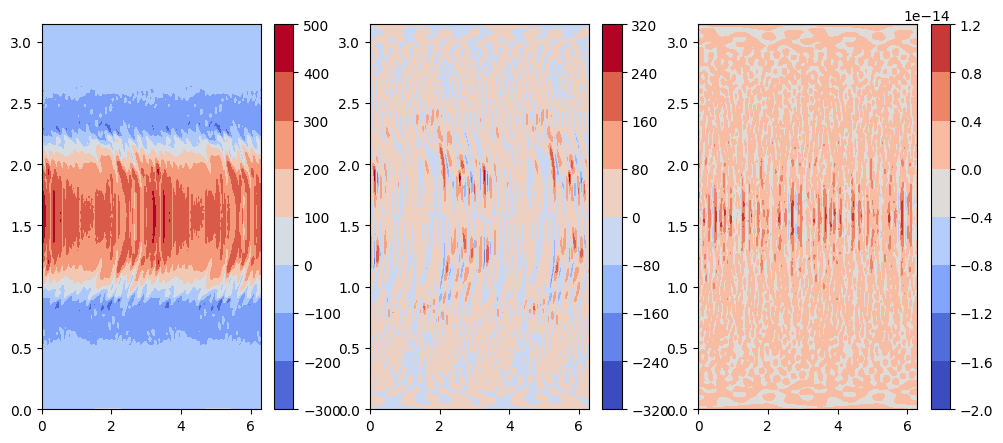

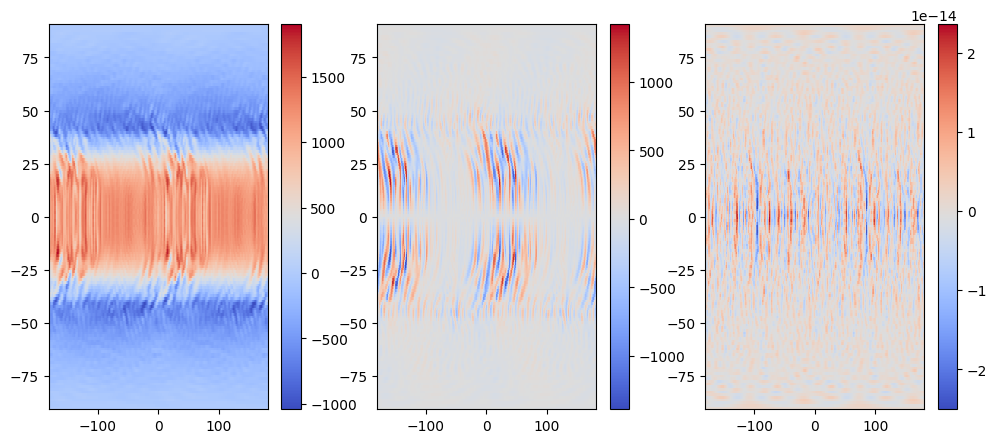

The lStart= [   0   97  192  285  376  465  552  637  720  801  880  957 1032 1105
 1176 1245 1312 1377 1440 1501 1560 1617 1672 1725 1776 1825 1872 1917
 1960 2001 2040 2077 2112 2145 2176 2205 2232 2257 2280 2301 2320 2337
 2352 2365 2376 2385 2392 2397 2400] 
 
 lStop= [  96  191  284  375  464  551  636  719  800  879  956 1031 1104 1175
 1244 1311 1376 1439 1500 1559 1616 1671 1724 1775 1824 1871 1916 1959
 2000 2039 2076 2111 2144 2175 2204 2231 2256 2279 2300 2319 2336 2351
 2364 2375 2384 2391 2396 2399 2400] 
 
 lmOdd= [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1]

 number of blocks= (49,)



In [8]:
if __name__=="__main__":
    version_G22,endian_G22,access_G22=check_endianness('G_22.test_BIS')
    list_vel_G22,list_geo_G22,minc_G22=read_stream_G('G_22.test_BIS',endian_G22)
    vr_G22,vtheta_G22,vphi_G22=list_vel_G22[0],list_vel_G22[1],list_vel_G22[2]
    nlon_G22,nlat_G22,nr=vr_G22.shape[0],vr_G22.shape[1],vr_G22.shape[2]
    vphi_outer_G22=vphi_G22[:,:,-1]
    vtheta_outer_G22=vtheta_G22[:,:,-1]
    vr_outer_G22=vr_G22[:,:,-1]
    #print("From G_files nlon=",nlon_G22,"\t nlat=",nlat_G22)
    vphi_outer_G22,vtheta_outer_G22,vr_outer_G22=vphi_outer_G22.T,vtheta_outer_G22.T,vr_outer_G22.T
    lon_G22=np.linspace(0,2*np.pi,nlon_G22*minc_G22)
    lat_G22=np.linspace(0,np.pi,nlat_G22)
    phi_grid_G22,theta_grid_G22=np.meshgrid(lon_G22,lat_G22)
    vphi_outer_G22,vtheta_outer_G22,vr_outer_G22=np.tile(vphi_outer_G22,(1,minc_G22)),np.tile(vtheta_outer_G22,(1,minc_G22)),np.tile(vr_outer_G22,(1,minc_G22))
    vmin_vphi,vmax_vphi=vphi_outer_G22.min(),vphi_outer_G22.max()
    vmin_vtheta,vmax_vtheta=vtheta_outer_G22.min(),vtheta_outer_G22.max()
    vmin_vr,vmax_vr=vr_outer_G22.min(),vr_outer_G22.max()
    print("The output from the G files are as follows in order phi, theta and radial")
    fig,axes=plt.subplots(1,3,figsize=(12,5))
    im0=axes[0].contourf(phi_grid_G22,theta_grid_G22,vphi_outer_G22,cmap='coolwarm',vmin=vmin_vphi,vmax=vmax_vphi)
    fig.colorbar(im0, ax=axes[0], orientation='vertical')
    im1=axes[1].contourf(phi_grid_G22,theta_grid_G22,vtheta_outer_G22,cmap='coolwarm',vmin=vmin_vtheta,vmax=vmax_vtheta)
    fig.colorbar(im1, ax=axes[1], orientation='vertical')
    im2=axes[2].contourf(phi_grid_G22,theta_grid_G22,vr_outer_G22,cmap='coolwarm',vmin=vmin_vr,vmax=vmax_vr)
    fig.colorbar(im2, ax=axes[2], orientation='vertical')
    version,params,rad_sph_params,omega,rad,rho_list,potentials=read_stream('V_lmr_1000.test_BIS')
    
    poloidal,toroidal=potentials[0],potentials[1]
    print(poloidal.shape)
    radius=rad[0]
    #contruct dpoldr to find the theta and phi components
    dpoldr=np.zeros_like(poloidal)
    dpoldr=matder(poloidal,radius,False)
    l_max,minc,lm_max,m_max,m_min=rad_sph_params[2],rad_sph_params[3],rad_sph_params[4],rad_sph_params[5],rad_sph_params[6]
    print("data from the potential files:\n","l_max=",l_max,"\t minc=",minc,"\t m_max=",m_max)
    n_theta=144
    print("\n n_theta max given manually =",n_theta)
    leg=Legendre(l_max,minc,n_theta,m_max)
    #print(leg.lStart,leg.lStop,leg.lmOdd)
    #print(leg.lStart.shape,leg.lStop.shape,leg.lmOdd.shape)
    vt,vp=leg._specspat_vec(dpoldr[:,0],toroidal[:,0],leg.n_theta_max,leg.n_phi_max)
    print("shape of vt=",vt.shape,"\t shape of vp=",vp.shape)
    vt=np.fft.ifft(vt,axis=0)*leg.n_phi_max#*leg.minc
    vp=np.fft.ifft(vp,axis=0)*leg.n_phi_max#*leg.minc
    vt,vp=vt.real,vp.real
    vt,vp=vt.T,vp.T

    #radial component
    inputLM=np.zeros_like(poloidal)
    indx,lm2l,lm2m=leg._LMmapping(m_min)
    for i in range(radius.shape[0]):
        inputLM[:,i]=poloidal[:,i]*lm2l*(lm2l+1)/radius[i]**2
    vr=leg._specspat_scal(inputLM[:,0],leg.n_theta_max,leg.n_phi_max)
    vr=np.fft.ifft(vr,axis=0)*leg.n_phi_max#*leg.minc
    vr=vr.real
    vr=vr.T
    print("shape of vr=",vr.shape)
    vt,vp,vr=np.tile(vt,(1,2)),np.tile(vp,(1,2)),np.tile(vr,(1,2))
    print("shape after tile vt =",vt.shape,"\t vp =",vp.shape,"\t vr=",vr.shape)
    nlon,nlat=vt.shape[1],vt.shape[0]
    print("new nlon =",nlon,"\t nlat =",nlat)
    phi_plot,theta_plot=np.linspace(0,leg.minc*np.pi,nlon),np.linspace(0,np.pi,nlat)
    phi_grid,theta_grid=np.meshgrid(phi_plot,theta_plot)
    phi_grid,theta_grid=phi_grid-np.pi,theta_grid-np.pi/2
    print("new phi grid =",phi_grid.shape,"\t new theta grid",theta_grid.shape)
    print("The output from potential file in the same order")
    vmin_vp,vmax_vp=vp.min(),vp.max()
    vmin_vt,vmax_vt=vt.min(),vt.max()
    vmin_vr,vmax_vr=vr.min(),vr.max()
    fig,axes=plt.subplots(1,3,figsize=(12,5))
    im0=axes[0].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vp,shading='auto',cmap='coolwarm',vmin=vmin_vp,vmax=vmax_vp)
    fig.colorbar(im0, ax=axes[0], orientation='vertical')
    im1=axes[1].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vt,shading='auto',cmap='coolwarm',vmin=vmin_vt,vmax=vmax_vt)
    fig.colorbar(im1, ax=axes[1], orientation='vertical')
    im2=axes[2].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vr,shading='auto',cmap='coolwarm',vmin=vmin_vr,vmax=vmax_vr)
    fig.colorbar(im2, ax=axes[2], orientation='vertical')
    #axes[0].contourf(vt)
    #axes[1].contourf(vp)
    print("maximum difference in the phi=",np.max(np.abs(vphi_outer_G22-vp)))
    print("maximum difference in the theta=",np.max(np.abs(vtheta_outer_G22-vt)))
    print("maximum difference in the radial=",np.max(np.abs(vr_outer_G22-vr)))
    
    plt.show()

    print("The lStart=",leg.lStart,"\n \n lStop=",leg.lStop,"\n \n lmOdd=",leg.lmOdd)
    print("\n number of blocks=",leg.lmOdd.shape)

    print()

    

In [9]:
#if __name__=="__main__":
    
    #version,params,rad_sph_params,omega,rad,rho_list,potentials=read_stream('V_lmr_1000.test_BIS')
    #poloidal,toroidal=potentials[0],potentials[1]
    #print(poloidal.shape)
    #radius=rad[0]
    #contruct dpoldr to find the theta and phi components
    #dpoldr=np.zeros_like(poloidal)
    #dpoldr=matder(poloidal,radius,False)
    #l_max,minc,lm_max,m_max,m_min=rad_sph_params[2],rad_sph_params[3],rad_sph_params[4],rad_sph_params[5],rad_sph_params[6]
    #print("data from the potential files:\n","l_max=",l_max,"\t minc=",minc,"\t m_max=",m_max)
    #n_theta=144
    #print("\n n_theta max given manually =",n_theta)
    #leg=Legendre(l_max,minc,n_theta,m_max)
    #El=np.zeros((leg.l_max,1))
    #idx,lm2l,lm2l=leg._LMmapping(m_min)
    #dpoldr_outer,toroidal_outer=dpoldr[:,0],toroidal[:,0]
    #inputLM=np.zeros_like(poloidal)
    #indx,lm2l,lm2m=leg._LMmapping(m_min)
    #for i in range(radius.shape[0]):
        #inputLM[:,i]=poloidal[:,i]*lm2l*(lm2l+1)/radius[i]**2
    #inputLM_outer=inputLM[:,0]
    #Em,Emt,Emp,Emr,m_list=[],[],[],[],[]
    #El,Elt,Elp,Elr,l_list=[],[],[],[],[]

    #for m in range(m_min,leg.m_max,leg.minc):
        #mask=leg._filter(lm2l,lm2m,None,m)
        #dpoldr_masked,toroidal_masked,inputLM_masked=dpoldr_outer*mask,toroidal_outer*mask,inputLM_outer*mask
        #vt,vp=leg._specspat_vec(dpoldr_masked,toroidal_masked,leg.n_theta_max,leg.n_phi_max)
        #vt=np.fft.ifft(vt,axis=0)*leg.n_phi_max#*leg.minc
        #vp=np.fft.ifft(vp,axis=0)*leg.n_phi_max#*leg.minc
        #vt,vp=vt.real,vp.real
        #vt,vp=vt.T,vp.T
        #vr=leg._specspat_scal(inputLM_masked,leg.n_theta_max,leg.n_phi_max)
        #vr=np.fft.ifft(vr,axis=0)*leg.n_phi_max#*leg.minc
        #vr=vr.real
        #vt,vp,vr=np.tile(vt,(1,2)),np.tile(vp,(1,2)),np.tile(vr,(1,2))
        #nlon,nlat=vt.shape[1],vt.shape[0]
        #phi_plot,theta_plot=np.linspace(0,leg.minc*np.pi,nlon),np.linspace(0,np.pi,nlat)
        #v2=vp**2+vt**2+vr**2
        #val_out=area_avg(v2,phi_plot,theta_plot)
        #Em.append(val_out)
        #val_out=area_avg(vp**2,phi_plot,theta_plot)
        #Emp.append(val_out)
        #val_out=area_avg(vt**2,phi_plot,theta_plot)
        #Emt.append(val_out)
        #val_out=area_avg(vr**2,phi_plot,theta_plot)
        #Emr.append(val_out)
        #m_list.append(m)

    #for l in range(0,leg.l_max):
        #mask=leg._filter(lm2l,lm2m,l,None)
        #dpoldr_masked,toroidal_masked,inputLM_masked=dpoldr_outer*mask,toroidal_outer*mask,inputLM_outer*mask
        #vt,vp=leg._specspat_vec(dpoldr_masked,toroidal_masked,leg.n_theta_max,leg.n_phi_max)
        #vt=np.fft.ifft(vt,axis=0)*leg.n_phi_max#*leg.minc
        #vp=np.fft.ifft(vp,axis=0)*leg.n_phi_max#*leg.minc
        #vt,vp=vt.real,vp.real
        #vt,vp=vt.T,vp.T
        #vr=leg._specspat_scal(inputLM_masked,leg.n_theta_max,leg.n_phi_max)
        #vr=np.fft.ifft(vr,axis=0)*leg.n_phi_max#*leg.minc
        #vr=vr.real
        #vt,vp,vr=np.tile(vt,(1,2)),np.tile(vp,(1,2)),np.tile(vr,(1,2))
        #nlon,nlat=vt.shape[1],vt.shape[0]
        #phi_plot,theta_plot=np.linspace(0,leg.minc*np.pi,nlon),np.linspace(0,np.pi,nlat)
        #v2=vp**2+vt**2+vr**2
        #val_out=area_avg(v2,phi_plot,theta_plot)
        #El.append(val_out)
        #val_out=area_avg(vp**2,phi_plot,theta_plot)
        #Elp.append(val_out)
        #val_out=area_avg(vt**2,phi_plot,theta_plot)
        #Elt.append(val_out)
        #val_out=area_avg(vr**2,phi_plot,theta_plot)
        #Elr.append(val_out)
        #l_list.append(l)    

    #for mcut in [1,5,100]:
        #mask=leg._filter(lm2l,lm2m,None,mcut)
        #dpoldr_masked,toroidal_masked,inputLM_masked=dpoldr_outer*mask,toroidal_outer*mask,inputLM_outer*mask
        #vt,vp=leg._specspat_vec(dpoldr_masked,toroidal_masked,leg.n_theta_max,leg.n_phi_max)
        #vt=np.fft.ifft(vt,axis=0)*leg.n_phi_max#*leg.minc
        #vp=np.fft.ifft(vp,axis=0)*leg.n_phi_max#*leg.minc
        #vt,vp=vt.real,vp.real
        #vt,vp=vt.T,vp.T
        #vr=leg._specspat_scal(inputLM_masked,leg.n_theta_max,leg.n_phi_max)
        #vr=np.fft.ifft(vr,axis=0)*leg.n_phi_max#*leg.minc
        #vr=vr.real
        #vr=vr.T
        #vt,vp,vr=np.tile(vt,(1,2)),np.tile(vp,(1,2)),np.tile(vr,(1,2))
        #vt,vp,vr=np.tile(vt,(1,2)),np.tile(vp,(1,2)),np.tile(vr,(1,2))
        #nlon,nlat=vt.shape[1],vt.shape[0]
        #phi_plot,theta_plot=np.linspace(0,leg.minc*np.pi,nlon),np.linspace(0,np.pi,nlat)
        #phi_grid,theta_grid=np.meshgrid(phi_plot,theta_plot)
        #phi_grid,theta_grid=phi_grid-np.pi,theta_grid-np.pi/2
        #vmin_vp,vmax_vp=vp.min(),vp.max()
        #vmin_vt,vmax_vt=vt.min(),vt.max()
        #vmin_vr,vmax_vr=vr.min(),vr.max()
        #fig,axes=plt.subplots(1,3,figsize=(12,5))
        #print("m cut =",mcut)
        #im0=axes[0].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vp,shading='auto',cmap='coolwarm',vmin=vmin_vp,vmax=vmax_vp)
        #fig.colorbar(im0, ax=axes[0], orientation='vertical')
        #im1=axes[1].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vt,shading='auto',cmap='coolwarm',vmin=vmin_vt,vmax=vmax_vt)
        #fig.colorbar(im1, ax=axes[1], orientation='vertical')
        #im2=axes[2].pcolormesh(np.degrees(phi_grid),np.degrees(theta_grid),vr,shading='auto',cmap='coolwarm',vmin=vmin_vr,vmax=vmax_vr)
        #fig.colorbar(im2, ax=axes[2], orientation='vertical')               

In [10]:
#Em,Emt,Emp,Emr,m_list=np.array(Em),np.array(Emt),np.array(Emp),np.array(Emr),np.array(m_list)
#El,Elt,Elp,Elr,l_list=np.array(El),np.array(Elt),np.array(Elp),np.array(Elr),np.array(l_list)
    #plt.loglog(m_list,Em,'k-',m_list,Emp,'r-',m_list,Emt,'g-')
    #plt.loglog(l_list,El,'k--',l_list,Elp,'r--',l_list,Elt,'g--')
    #plt.legend(['E','Ep','Et'])
    #plt.loglog(m_list,Em,'k-',m_list,Emp,'r-',m_list,Emt,'g-',m_list,Emr,'b-')
    #plt.legend(['E','Ep','Et','Er'])
#width_tick_params,length_tick_params=6,8
#spine_width=5

#fig,axes=plt.subplots(1,2,figsize=(15,8))
#axes[0].loglog(l_list,El,l_list,Elp,l_list,Elt,lw=2.5)
#axes[0].set_title("spectra vs l",fontsize=16)
#axes[0].legend(['Et','Ep','Et'],fontsize=28)

#axes[1].loglog(m_list,Em,m_list,Emp,m_list,Emt,lw=2.5)
#axes[1].set_title("spectra vs m",fontsize=16)
#axes[1].legend(['Et','Ep','Et'],fontsize=28)

    
    #axes[0].loglog(l_list,El,l_list,Elp,l_list,Elt,l_list,Elr,lw=2.5)
    #axes[0].set_title("spectra vs l",fontsize=16)
    #axes[0].legend(['E','Ep','Et','Er'],fontsize=28)

    #axes[1].loglog(m_list,Em,m_list,Emp,m_list,Emt,m_list,Emr,lw=2.5)
    #axes[1].set_title("spectra vs m",fontsize=16)
    #axes[1].legend(['E','Ep','Et','Er'],fontsize=28)

#for ax in axes:
    #ax.tick_params(axis='both', labelsize=14,width=width_tick_params,length=length_tick_params)
    #for spine in ax.spines.values():
        #spine.set_linewidth(spine_width)

#plt.tight_layout()
#plt.show()

In [11]:
if __name__=="__main__":
    version,params,rad_sph_params,omega,rad,rho_list,potentials=read_stream('V_lmr_1000.test_BIS')
    poloidal,toroidal=potentials[0],potentials[1]
    print(poloidal.shape)
    radius=rad[0]
    #contruct dpoldr to find the theta and phi components
    dpoldr=np.zeros_like(poloidal)
    dpoldr=matder(poloidal,radius,False)
    l_max,minc,lm_max,m_max,m_min=rad_sph_params[2],rad_sph_params[3],rad_sph_params[4],rad_sph_params[5],rad_sph_params[6]
    print("data from the potential files:\n","l_max=",l_max,"\t minc=",minc,"\t m_max=",m_max)
    n_theta=144
    print("\n n_theta max given manually =",n_theta)
    leg=Legendre(l_max,minc,n_theta,m_max)
    idx,lm2l,lm2m=leg._LMmapping(m_min)
    lm_in=leg._getLM(idx,m_min)
    lm_in=np.array(lm_in)
    print(lm_in,)
    LM_padded=leg._pad_lm_array(lm_in,1.5)
    print(LM_padded,LM_padded.shape)

time from potential file= 0.9499
(2401, 97)
data from the potential files:
 l_max= 96 	 minc= 2 	 m_max= 96

 n_theta max given manually = 144
shape of LM list= 2401
[   0    1    2 ... 2398 2399 2400]
new n_m_max: 144 	 old m_max 96
LM2D shape= (97, 145)
[   0    1    2 ... 2398 2399 2400] (2401,)
